## **Taller 2**

1. Realizar exploración de conjunto de datos
2. Extraer características usando modelo per-entrenado (Resnet50, MobileNet,…)
3. Entrenar cabeza de clasificación (recomendado: AutoGluon)
4. Evaluar desempeño de modelo

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [2]:

# Ruta al archivo de anotaciones
annotation_file = r'C:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\2-Clasificación\Dataset\train\annotation.txt'  # reemplaza con la tuya

# Cargar las líneas válidas (nombre + 12 valores)
column_names = ['filename'] + [f'class_{i}' for i in range(1, 13)]
clean_data = []

with open(annotation_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 13:
            clean_data.append(parts)

df = pd.DataFrame(clean_data, columns=column_names)

# Convertir valores a float
for col in column_names[1:]:
    df[col] = df[col].astype(float)

# Eliminar extensión si es necesario
df['filename'] = df['filename'].apply(lambda x: os.path.splitext(x)[0])


## 1. Exploracion del conjunto de datos

In [3]:
df

,filename,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,class_11,class_12
0,000000,-1.0,-1.00,-1.00,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,000001,-1.0,1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,000002,-1.0,-1.00,1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,000003,-1.0,1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,000004,-1.0,1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,039995,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
39996,039996,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
39997,039997,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
39998,039998,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [4]:
# Ruta a la carpeta train/
train_dir = r'C:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\2-Clasificación\Dataset\train'

# Buscar todas las imágenes .jpg en subcarpetas
all_images = glob(os.path.join(train_dir, '*', '*.jpg'))

# Mapear nombre base (sin extensión) a ruta completa
image_map = {os.path.splitext(os.path.basename(p))[0]: p for p in all_images}

# Asignar ruta real en el DataFrame
df['ruta_real'] = df['filename'].map(image_map)

# Verificar qué tantas rutas se asignaron
print("Rutas encontradas:", df['ruta_real'].notna().sum())
print("Faltantes:", df['ruta_real'].isna().sum())


Rutas encontradas: 40000
Faltantes: 0


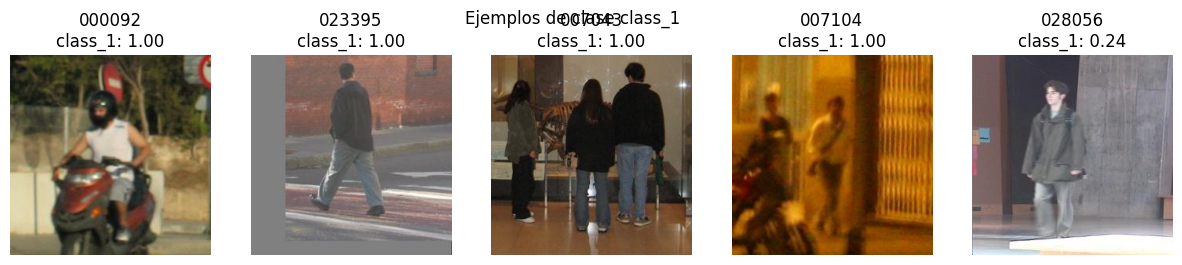

In [5]:
def mostrar_ejemplos(clase_idx, n=5):
    clase = f'class_{clase_idx}'
    subset = df[df[clase] > 0].dropna(subset=['ruta_real']).sample(n)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for ax, row in zip(axs, subset.itertuples()):
        try:
            img = Image.open(row.ruta_real)
            ax.imshow(img)
            ax.set_title(f"{row.filename}\n{clase}: {getattr(row, clase):.2f}")
        except:
            ax.text(0.5, 0.5, 'Error', ha='center')
        ax.axis('off')
    plt.suptitle(f"Ejemplos de clase {clase}")
    plt.show()

mostrar_ejemplos(1)


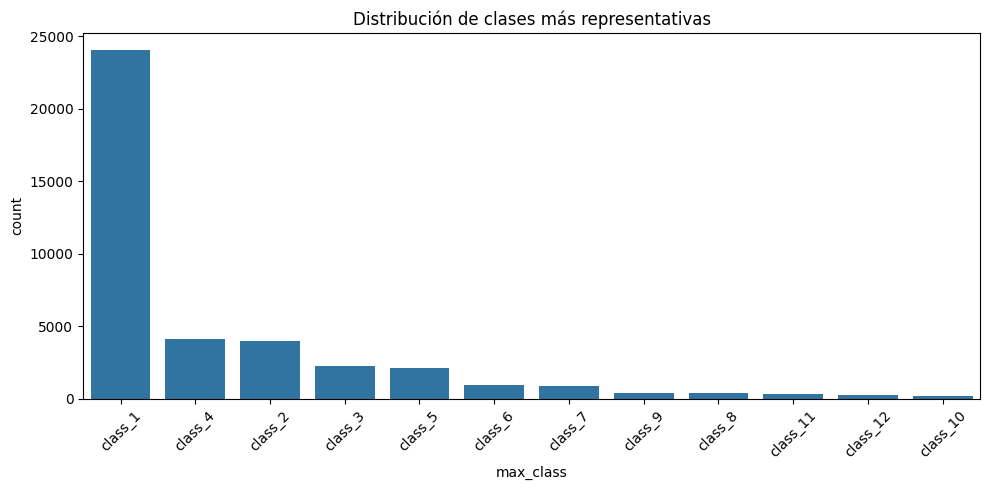

In [6]:
# Etiqueta más fuerte por imagen
df['max_class'] = df[[f'class_{i}' for i in range(1, 13)]].idxmax(axis=1)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='max_class', order=df['max_class'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribución de clases más representativas")
plt.tight_layout()
plt.show()


In [7]:
# Identificar imagenes corruptas
def is_corrupt(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return False
    except:
        return True

df['corrupta'] = df['ruta_real'].apply(is_corrupt)
print("Imágenes corruptas:", df['corrupta'].sum())


Imágenes corruptas: 0


In [8]:
path = df['ruta_real'].iloc[0]
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
print("Imagen cargada:", type(img))

Imagen cargada: <class 'NoneType'>


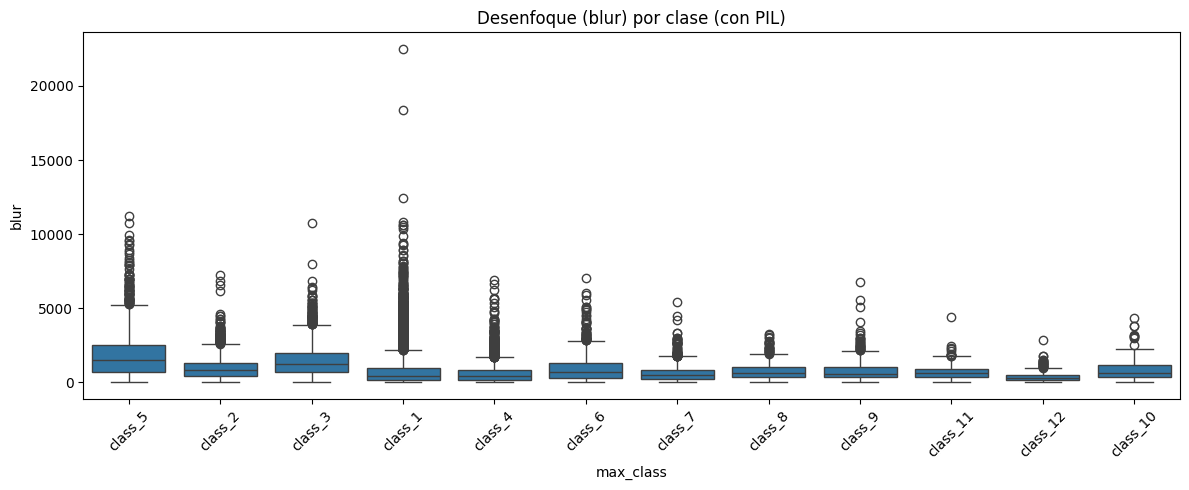

In [9]:
# Analizar desenfoque con varianza del Laplaciano
def calcular_blur_pil(path):
    try:
        with Image.open(path).convert('L') as img:  # Convertir a escala de grises
            img_np = np.array(img)
            return cv2.Laplacian(img_np, cv2.CV_64F).var()
    except Exception as e:
        print(f"Error en {path}: {e}")
        return -1
    
df['blur'] = df['ruta_real'].apply(calcular_blur_pil)

plt.figure(figsize=(12, 5))
sns.boxplot(data=df[df['blur'] > 0], x='max_class', y='blur')
plt.xticks(rotation=45)
plt.title("Desenfoque (blur) por clase (con PIL)")
plt.tight_layout()
plt.show()

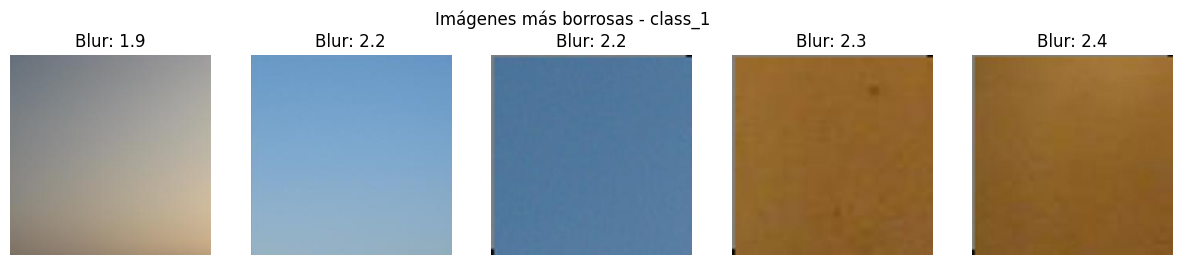

In [10]:
#Ejemplos de imagenes nitidas vs desenfocadas
def mostrar_por_blur(df, clase, alto=True, n=5):
    subset = df[df['max_class'] == clase]
    subset = subset[subset['blur'] > 0].sort_values('blur', ascending=not alto).head(n)

    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for ax, row in zip(axs, subset.itertuples()):
        img = Image.open(row.ruta_real)
        ax.imshow(img)
        ax.set_title(f"Blur: {row.blur:.1f}")
        ax.axis('off')
    titulo = f"Imágenes {'más nítidas' if alto else 'más borrosas'} - {clase}"
    plt.suptitle(titulo)
    plt.show()

# Ejemplo:
mostrar_por_blur(df, clase='class_1', alto=False)  # Imágenes más borrosas de class_1


In [11]:
resumen_blur = df.groupby('max_class')['blur'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print(resumen_blur)

           count     mean      std    min       max
max_class                                          
class_1    24023   720.19   865.07   1.88  22499.16
class_10     223   850.17   719.76   5.10   4339.83
class_11     350   696.79   487.01  20.22   4367.07
class_12     269   383.52   375.02  14.02   2848.01
class_2     3976   930.76   696.48  13.19   7247.81
class_3     2238  1491.62  1074.92  25.12  10735.60
class_4     4146   606.12   666.23   4.80   6925.17
class_5     2087  1841.14  1529.41   7.39  11213.05
class_6      969   960.67   949.99  10.70   7005.15
class_7      886   633.58   615.51  11.28   5398.07
class_8      405   783.44   596.49  11.65   3238.67
class_9      428   808.10   794.86  26.54   6740.61


## 2. Extraer caracteristicas usando modelo preentrenado

In [12]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Cargar modelo MobileNetV2 sin la última capa (solo extracción de características)
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Función para procesar una imagen
def extraer_features(path):
    try:
        img = load_img(path, target_size=(224, 224))  # redimensiona
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = mobilenet.predict(img_array, verbose=0)
        return features.flatten()
    except Exception as e:
        print("Error con:", path)
        return None

# Aplicar a las imágenes válidas
tqdm.pandas()
df_validas = df[df['ruta_real'].notna()].copy()
df_validas['features'] = df_validas['ruta_real'].progress_apply(extraer_features)

# Filtrar y guardar solo las que funcionaron
df_features = df_validas[df_validas['features'].notna()].copy()


C:\Users\Melissa\AppData\Local\Temp\ipykernel_23392\2091448984.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 40000/40000 [52:58<00:00, 12.59it/s]  


## 3. Entrenar cabeza de clasificación (recomendado: AutoGluon)

In [13]:
from autogluon.tabular import TabularPredictor

# Convertir features a columnas individuales
features_df = pd.DataFrame(df_features['features'].to_list())
features_df['label'] = df_features['max_class'].values  # Etiquetas

# Guardar por claridad
train_data = features_df.copy()


In [14]:
predictor = TabularPredictor(label='label', path='autogluon_model').fit(
    train_data,
    time_limit=300,  # segundos para limitar el tiempo de entrenamiento
    presets='best_quality'  # también puedes usar 'medium_quality_faster_train'
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       4.16 GB / 15.63 GB (26.6%)
Disk Space Avail:   188.71 GB / 449.33 GB (42.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up 

In [15]:
performance = predictor.evaluate(train_data)
print("Desempeño del modelo:")
print(performance)

Desempeño del modelo:
{'accuracy': 0.696675, 'balanced_accuracy': np.float64(0.30189293855436744), 'mcc': np.float64(0.43832971643595936)}


In [16]:
predicciones = predictor.predict(train_data.drop(columns='label'))
print(predicciones.head())

from sklearn.metrics import accuracy_score
acc = accuracy_score(train_data['label'], predicciones)
print(f"Accuracy sobre el mismo conjunto: {acc:.4f}")


0    class_1
1    class_2
2    class_1
3    class_1
4    class_1
Name: label, dtype: object
Accuracy sobre el mismo conjunto: 0.6967


## 4. Evaluacion de desempeño

In [17]:
# Leer archivo de anotaciones del test
test_annotation = r'C:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\2-Clasificación\Dataset\test\annotation.txt'
test_image_dir = r'C:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\2-Clasificación\Dataset\test'  # carpeta que contiene subcarpetas 0000-0009

lines = []
with open(test_annotation, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 13:
            lines.append(parts)

test_df = pd.DataFrame(lines, columns=['filename'] + [f'class_{i}' for i in range(1, 13)])
for col in test_df.columns[1:]:
    test_df[col] = test_df[col].astype(float)
test_df['max_class'] = test_df[[f'class_{i}' for i in range(1, 13)]].idxmax(axis=1)


In [19]:
# Mapear rutas reales
test_images = glob(os.path.join(test_image_dir, '*', '*.jpg'))
img_map_test = {os.path.splitext(os.path.basename(p))[0]: p for p in test_images}
test_df['ruta_real'] = test_df['filename'].map(img_map_test)


In [20]:
# Reusar modelo cargado previamente
def extraer_features(path):
    try:
        img = load_img(path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = mobilenet.predict(img_array, verbose=0)
        return features.flatten()
    except:
        return None

test_df['features'] = test_df['ruta_real'].apply(extraer_features)
test_features = test_df[test_df['features'].notna()].copy()


In [21]:
X_test = pd.DataFrame(test_features['features'].to_list())
y_test = test_features['max_class'].values

In [22]:
y_pred = predictor.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy en test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy en test: 0.6775
              precision    recall  f1-score   support

     class_1       0.65      0.99      0.79      5936
    class_10       0.50      0.03      0.06        64
    class_11       0.96      0.51      0.67        84
    class_12       0.90      0.28      0.42        65
     class_2       0.96      0.49      0.65      1017
     class_3       0.00      0.00      0.00       586
     class_4       0.98      0.23      0.38      1043
     class_5       0.00      0.00      0.00       546
     class_6       1.00      0.08      0.16       259
     class_7       0.00      0.00      0.00       191
     class_8       0.90      0.37      0.52       103
     class_9       0.79      0.10      0.18       106

    accuracy                           0.68     10000
   macro avg       0.64      0.26      0.32     10000
weighted avg       0.65      0.68      0.59     10000



c:\Users\Melissa\Ambientes\venv_vision\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Melissa\Ambientes\venv_vision\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Melissa\Ambientes\venv_vision\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

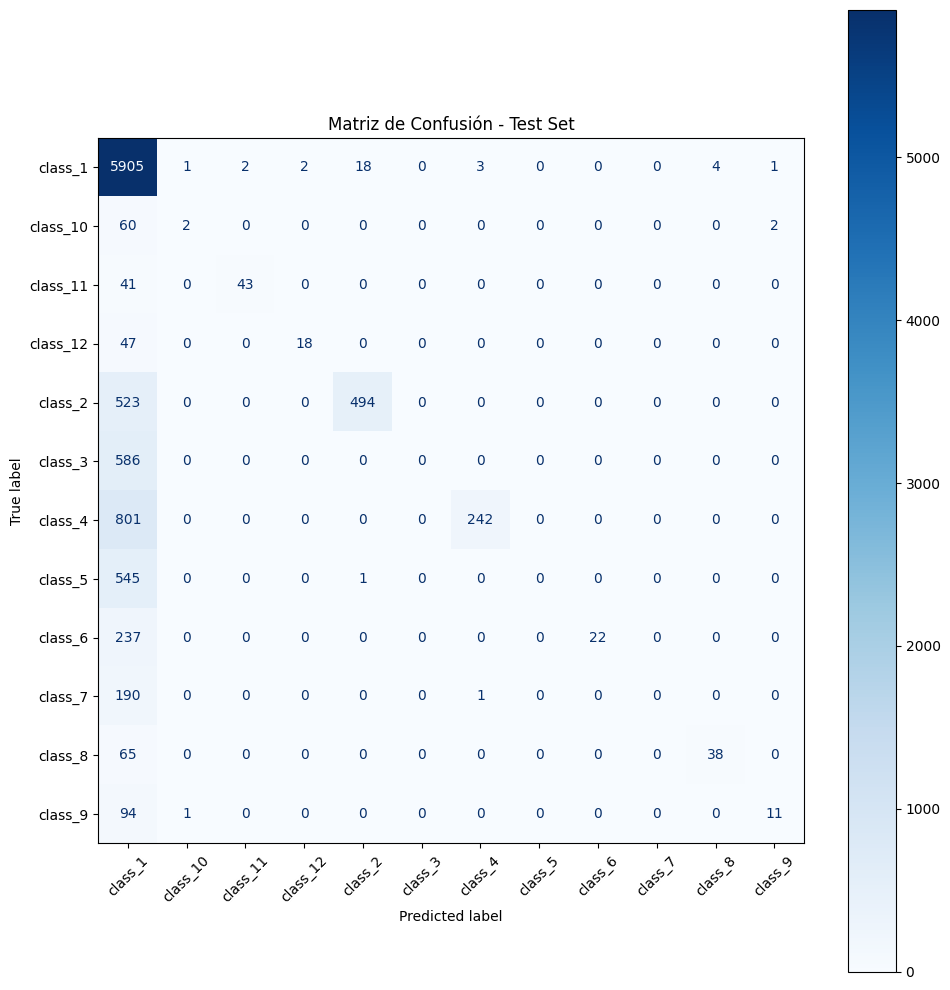

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=predictor.class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("Matriz de Confusión - Test Set")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.utils import resample
import pandas as pd

# 1. Asumimos que este es tu DataFrame original con características y etiqueta
train_data = features_df.copy()  # asegúrate que esto tenga 'label'

# 2. Revisamos cuántas muestras hay por clase
print(train_data['label'].value_counts())

# 3. Determinar la cantidad mínima de muestras entre las clases
min_count = train_data['label'].value_counts().min()

# 4. Submuestreo (undersampling) para balancear
balanced_data = pd.concat([
    resample(group, replace=False, n_samples=min_count, random_state=42)
    for _, group in train_data.groupby('label')
])

# 5. Verificamos que ahora estén balanceadas
print(balanced_data['label'].value_counts())

# 6. Entrenamos nuevamente con AutoGluon usando el set balanceado
from autogluon.tabular import TabularPredictor

predictor_balanced = TabularPredictor(label='label', path='autogluon_model_balanced').fit(
    train_data=balanced_data,
    time_limit=300,
    presets='best_quality'
)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.29 GB / 15.63 GB (21.0%)
Disk Space Avail:   186.79 GB / 449.33 GB (41.6%)


label
class_1     24023
class_4      4146
class_2      3976
class_3      2238
class_5      2087
class_6       969
class_7       886
class_9       428
class_8       405
class_11      350
class_12      269
class_10      223
Name: count, dtype: int64
label
class_1     223
class_10    223
class_11    223
class_12    223
class_2     223
class_3     223
class_4     223
class_5     223
class_6     223
class_7     223
class_8     223
class_9     223
Name: count, dtype: int64


Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting.
	Running DyStack for up to 75s of the 300s of remaining time (25%).
		Context path: "c:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\2-Clasificación\autogluon_model_balanced\ds_sub_fit\sub_fit_ho"
Leaderboard on holdout data (DyStack):
                    model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pre

In [59]:
y_pred_balanced = predictor_balanced.predict(X_test)
print("Accuracy en test con datos balanceados:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

Accuracy en test con datos balanceados: 0.6674
              precision    recall  f1-score   support

     class_1       0.99      0.58      0.73      5936
    class_10       0.11      0.61      0.19        64
    class_11       0.50      0.99      0.66        84
    class_12       0.23      0.91      0.36        65
     class_2       0.79      0.93      0.85      1017
     class_3       0.38      0.69      0.49       586
     class_4       0.82      0.75      0.78      1043
     class_5       0.42      0.80      0.55       546
     class_6       0.42      0.78      0.55       259
     class_7       0.23      0.71      0.35       191
     class_8       0.48      0.95      0.63       103
     class_9       0.32      0.72      0.44       106

    accuracy                           0.67     10000
   macro avg       0.47      0.78      0.55     10000
weighted avg       0.83      0.67      0.70     10000



* Recall promedio (macro) subió de ~0.26 a 0.78. Esto significa que el modelo ahora detecta mucho mejor las clases minoritarias.
* Clases como class_3, class_5, class_7, class_8 y class_10 pasaron de tener recall cercano a 0 a valores entre 0.6 y 0.9.
* El weighted avg f1-score subió de 0.59 a 0.70 ⇒ mejor equilibrio entre precisión y recall, ponderado por soporte.